In [ ]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import drive
import nltk

import pandas as pd
import numpy as np
import io
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

AttributeError: partially initialized module 'nltk' has no attribute 'data' (most likely due to a circular import)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# !kaggle datasets download -d shivamb/real-or-fake-fake-jobposting-prediction --force

nltk.download('punkt')
nltk.download('wordnet')

Mounted at /content/gdrive


NameError: name 'nltk' is not defined

In [ ]:
import os
import pandas as pd
dataset_dir = '/content/gdrive/MyDrive/Essentials in Text and Speech Processing'
csv_path = os.path.join(dataset_dir, 'fake_job_postings.csv')
df = pd.read_csv(csv_path)

In [ ]:
df.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Import the data and split it into train and test sets

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/Essentials in Text and Speech Processing'
csv_path = os.path.join(dataset_dir, 'fake_job_postings.csv')
df = pd.read_csv(csv_path)

# The dataset has job_id which we do not need
df = df.drop(['job_id'], axis=1)

# The 'location' feature has inconsistencies so we standardize the format by splitting the 'location' column into Country, State, and City
def split_location(location):
    # Split the location by commas
    parts = location.split(',')

    # Ensure the list has 3 elements (Country, State, City), fill missing with 'Unknown'
    while len(parts) < 3:
        parts.append('Unknown')  # Add 'Unknown' for missing elements

    return parts[:3]  # In case there are more than 3 parts

# Make sure there are no missing values in 'location'
df['location'] = df['location'].fillna('Unknown')

# Apply the function to the 'location' column
df[['country', 'state', 'city']] = df['location'].apply(lambda loc: split_location(loc)).apply(pd.Series)

# Now fill any remaining NaN values with 'Unknown' just in case
df[['country', 'state', 'city']] = df[['country', 'state', 'city']].fillna('Unknown')

x = df.drop(['fraudulent'], axis=1) # Features
y = df['fraudulent'] # Labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

Training set shape: (14304, 19) (14304,)
Testing set shape: (3576, 19) (3576,)


Different types of metadata means we have to implement different strategies to handle different features. We have 16 features which are considered respectively and handled accordingly. Below are some helper functions for feature handling.

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

# Function to clean symbols from text
def clean_text(text):
    # Replace non-alphabet characters with a space
    return re.sub(r'[^a-z\s]', '', text)

# Function to see the percentage of null values in a column
def null_percentage(df, column_name):
    # Check if the column exists in the DataFrame
    if column_name in df.columns:
        # Calculate the percentage of null values in the specified column
        total_rows = df.shape[0]
        null_count = df[column_name].isnull().sum()
        null_percentage = (null_count / total_rows) * 100
        return round(null_percentage, 2)  # Round to 2 decimal places
    else:
        # If the column doesn't exist, return a message
        return f"Column '{column_name}' does not exist in the DataFrame."

Title feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['title'].isnull().values.any())
print(x_test['title'].isnull().values.any())
# No null values

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limiting to 1000 features

# Fit the vectorizer on the training set and transform both train and test sets
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train['title'])
x_test_tfidf = tfidf_vectorizer.transform(x_test['title'])

False
False


Location feature

In [ ]:
# We have already handled empty values for 'location'
# Now we have three columns that contribute to the 'location' feature: country, state, city
# Because of the high cardinality of features, one-hot encoding is inefficient
# We proceed with frequency encoding
# This might cause problems if the test data has values that do not exist in train data, CAREFUL

# Frequency encoding for country
country_freq = x_train['country'].value_counts()
x_train['country_encoded'] = x_train['country'].map(country_freq)

# Frequency encoding for state
state_freq = x_train['state'].value_counts()
x_train['state_encoded'] = x_train['state'].map(state_freq)

# Frequency encoding for city
city_freq = x_train['city'].value_counts()
x_train['city_encoded'] = x_train['city'].map(city_freq)

# Frequency encoding for x_test based on x_train frequencies
x_test['country_encoded'] = x_test['country'].map(country_freq).fillna(0)
x_test['state_encoded'] = x_test['state'].map(state_freq).fillna(0)
x_test['city_encoded'] = x_test['city'].map(city_freq).fillna(0)

# Drop the location and the country, state, and city as they are useless now
x_train = x_train.drop(['location'], axis=1)
x_train = x_train.drop(['country'], axis=1)
x_train = x_train.drop(['state'], axis=1)
x_train = x_train.drop(['city'], axis=1)
x_test = x_test.drop(['location'], axis=1)
x_test = x_test.drop(['country'], axis=1)
x_test = x_test.drop(['state'], axis=1)
x_test = x_test.drop(['city'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

Training set shape: (14304, 18) (14304,)
Testing set shape: (3576, 18) (3576,)


Department Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['department'].isnull().values.any())
print(x_test['department'].isnull().values.any())

# Check null percentage
department_null_percentage = null_percentage(df, 'department')
print(f"Percentage of null values in 'department' column: {department_null_percentage}%")

# Null percentage too high, it can be better to just drop the feature
# We check the linear correlation just in case
# Linear correlation does not account for non-linear relationships, but it is a good indicator regardless

# Convert department to frequency encoding or another encoding
department_freq = df['department'].value_counts()
df['department_encoded'] = df['department'].map(department_freq)

# Correlation between department and target
correlation = df[['department_encoded', 'fraudulent']].corr()
print(correlation)

# Drop it, too much null values ~65% and low linear correlation
df = df.drop(['department'], axis=1)
df = df.drop(['department_encoded'], axis=1)
x_train = x_train.drop(['department'], axis=1)
x_test = x_test.drop(['department'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

True
True
Percentage of null values in 'department' column: 64.58%
                    department_encoded  fraudulent
department_encoded            1.000000   -0.049204
fraudulent                   -0.049204    1.000000
Training set shape: (14304, 17) (14304,)
Testing set shape: (3576, 17) (3576,)


Salary-Range Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['salary_range'].isnull().values.any())
print(x_test['salary_range'].isnull().values.any())

# Check null percentage
salary_null_percentage = null_percentage(df, 'salary_range')
print(f"Percentage of null values in 'salary_range' column: {salary_null_percentage}%")

# Null percentage too high, it can be better to just drop the feature
# We check the linear correlation just in case
# Linear correlation does not account for non-linear relationships, but it is a good indicator regardless

# Convert department to frequency encoding or another encoding
salary_freq = df['salary_range'].value_counts()
df['salary_range_encoded'] = df['salary_range'].map(salary_freq)

# Correlation between department and target
correlation = df[['salary_range_encoded', 'fraudulent']].corr()
print(correlation)

# Drop it, too much null values ~84% and low linear correlation
df = df.drop(['salary_range'], axis=1)
df = df.drop(['salary_range_encoded'], axis=1)
x_train = x_train.drop(['salary_range'], axis=1)
x_test = x_test.drop(['salary_range'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

True
True
Percentage of null values in 'salary_range' column: 83.96%
                      salary_range_encoded  fraudulent
salary_range_encoded              1.000000   -0.056682
fraudulent                       -0.056682    1.000000
Training set shape: (14304, 16) (14304,)
Testing set shape: (3576, 16) (3576,)


Company profile feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['company_profile'].isnull().values.any())
print(x_test['company_profile'].isnull().values.any())

# Check null percentage
company_null_percentage = null_percentage(df, 'company_profile')
print(f"Percentage of null values in 'company_profile' column: {company_null_percentage}%")
# Acceptable, ~18.5%

# Insert "unknown" in place of null values
x_train['company_profile'] = x_train['company_profile'].fillna('unknown')
x_test['company_profile'] = x_test['company_profile'].fillna('unknown')

# Lowercasing
x_train['company_profile'] = x_train['company_profile'].str.lower()
x_test['company_profile'] = x_test['company_profile'].str.lower()

# Remove punctuation marks and special characters
x_train['company_profile'] = x_train['company_profile'].str.replace('[^\w\s]', '', regex=True)
x_test['company_profile'] = x_test['company_profile'].str.replace('[^\w\s]', '', regex=True)

# Lemmatization
lemmatizer = WordNetLemmatizer()

x_train['company_profile'] = x_train['company_profile'].apply(lemmatize_text)
x_test['company_profile'] = x_test['company_profile'].apply(lemmatize_text)

# Now we can vectorize the company profile feature
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train['company_profile'])
X_test_tfidf = tfidf_vectorizer.transform(x_test['company_profile'])

True
True
Percentage of null values in 'company_profile' column: 18.5%


Description feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['description'].isnull().values.any())
print(x_test['description'].isnull().values.any())

# Check null percentage
description_null_percentage = null_percentage(df, 'description')
print(f"Percentage of null values in 'description' column: {description_null_percentage}%")
# Acceptable, ~0.01%

# Insert "unknown" in place of null values
x_train['description'] = x_train['description'].fillna('unknown')
x_test['description'] = x_test['description'].fillna('unknown')

# Lowercasing
x_train['description'] = x_train['description'].str.lower()
x_test['description'] = x_test['description'].str.lower()

# Remove punctuation marks and special characters
x_train['description'] = x_train['description'].str.replace('[^\w\s]', '', regex=True)
x_test['description'] = x_test['description'].str.replace('[^\w\s]', '', regex=True)

# Lemmatize
x_train['description'] = x_train['description'].apply(lemmatize_text)
x_test['description'] = x_test['description'].apply(lemmatize_text)

# Now we can vectorize the description feature
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train['description'])
X_test_tfidf = tfidf_vectorizer.transform(x_test['description'])

True
False
Percentage of null values in 'description' column: 0.01%


Requirements feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['requirements'].isnull().values.any())
print(x_test['requirements'].isnull().values.any())

# Check null percentage
requirements_null_percentage = null_percentage(df, 'requirements')
print(f"Percentage of null values in 'requirements' column: {requirements_null_percentage}%")
# Acceptable, ~15.08%

# Insert "unknown" in place of null values
x_train['requirements'] = x_train['requirements'].fillna('unknown')
x_test['requirements'] = x_test['requirements'].fillna('unknown')

# Lowercasing
x_train['requirements'] = x_train['requirements'].str.lower()
x_test['requirements'] = x_test['requirements'].str.lower()

# Remove punctuation marks and special characters
x_train['requirements'] = x_train['requirements'].str.replace('[^\w\s]', '', regex=True)
x_test['requirements'] = x_test['requirements'].str.replace('[^\w\s]', '', regex=True)

# Lemmatize
x_train['requirements'] = x_train['requirements'].apply(lemmatize_text)
x_test['requirements'] = x_test['requirements'].apply(lemmatize_text)

# Now we can vectorize the description feature
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train['requirements'])
X_test_tfidf = tfidf_vectorizer.transform(x_test['requirements'])

True
True
Percentage of null values in 'requirements' column: 15.08%


Benefits Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['requirements'].isnull().values.any())
print(x_test['requirements'].isnull().values.any())

# Check null percentage
benefits_null_percentage = null_percentage(df, 'benefits')
print(f"Percentage of null values in 'benefits' column: {benefits_null_percentage}%")

# Null percentage too high, it can be better to just drop the feature
# We check the linear correlation just in case
# Linear correlation does not account for non-linear relationships, but it is a good indicator regardless

# Convert benefits to frequency encoding or another encoding
benefits_freq = df['benefits'].value_counts()
df['benefits_encoded'] = df['benefits'].map(benefits_freq)

# Correlation between department and target
correlation = df[['benefits_encoded', 'fraudulent']].corr()
print(correlation)

# Drop it, too much null values ~40.34% and low linear correlation
df = df.drop(['benefits'], axis=1)
df = df.drop(['benefits_encoded'], axis=1)
x_train = x_train.drop(['benefits'], axis=1)
x_test = x_test.drop(['benefits'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

False
False
Percentage of null values in 'benefits' column: 40.34%
                  benefits_encoded  fraudulent
benefits_encoded          1.000000   -0.063022
fraudulent               -0.063022    1.000000
Training set shape: (14304, 15) (14304,)
Testing set shape: (3576, 15) (3576,)


Telecommuting Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['telecommuting'].isnull().values.any())
print(x_test['telecommuting'].isnull().values.any())
# No null values

False
False


Has-Company-Logo Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['has_company_logo'].isnull().values.any())
print(x_test['has_company_logo'].isnull().values.any())
# No null values

False
False


Has-Questions Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['has_questions'].isnull().values.any())
print(x_test['has_questions'].isnull().values.any())
# No null values

False
False


Employement Type Feature

In [ ]:
# For employment_type => ['Full-time' nan 'Contract' 'Part-time' 'Other' 'Temporary']

# If we have null values, we have to handle them first
print(x_train['employment_type'].isnull().values.any())
print(x_test['employment_type'].isnull().values.any())

# Insert "unknown" in place of null values
x_train['employment_type'] = x_train['employment_type'].fillna('unknown')
x_test['employment_type'] = x_test['employment_type'].fillna('unknown')

# Lowercasing
x_train['employment_type'] = x_train['employment_type'].str.lower()
x_test['employment_type'] = x_test['employment_type'].str.lower()

# Apply one-hot encoding
x_train = pd.get_dummies(x_train, columns=['employment_type'], prefix='employment_type')
x_test = pd.get_dummies(x_test, columns=['employment_type'], prefix='employment_type')

# Align columns between train and test sets to make sure they match
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

# No need to drop the column as pd.get_dummies has dealt with it already
# x_train = x_train.drop(['employment_type'], axis=1)
# x_test = x_test.drop(['employment_type'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

True
True
Training set shape: (14304, 20) (14304,)
Testing set shape: (3576, 20) (3576,)


Required Experience Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['required_experience'].isnull().values.any())
print(x_test['required_experience'].isnull().values.any())

# Insert "unknown" in place of null values
x_train['required_experience'] = x_train['required_experience'].fillna('unknown')
x_test['required_experience'] = x_test['required_experience'].fillna('unknown')

# Lowercasing
x_train['required_experience'] = x_train['required_experience'].str.lower()
x_test['required_experience'] = x_test['required_experience'].str.lower()

# Remove punctuation marks and special characters
x_train['required_experience'] = x_train['required_experience'].str.replace('[^\w\s]', '', regex=True)
x_test['required_experience'] = x_test['required_experience'].str.replace('[^\w\s]', '', regex=True)

# Define the order of experience levels, derived from the dataset
experience_levels = {
    'internship': 1,
    'entry level': 2,
    'associate': 3,
    'midsenior level': 4,
    'director': 5,
    'executive': 6,
    'not applicable': 0,  # or another value if "Not Applicable" isn't part of the hierarchy
    'unknown': -1         # a placeholder value if necessary for missing data
}

# Map the levels to the feature
x_train['required_experience_encoded'] = x_train['required_experience'].map(experience_levels)
x_test['required_experience_encoded'] = x_test['required_experience'].map(experience_levels)

# Drop the original column
x_train = x_train.drop(['required_experience'], axis=1)
x_test = x_test.drop(['required_experience'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

True
True
Training set shape: (14304, 20) (14304,)
Testing set shape: (3576, 20) (3576,)


Required Education Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['required_education'].isnull().values.any())
print(x_test['required_education'].isnull().values.any())

# Insert "unknown" in place of null values
x_train['required_education'] = x_train['required_education'].fillna('unknown')
x_test['required_education'] = x_test['required_education'].fillna('unknown')

# Lowercasing
x_train['required_education'] = x_train['required_education'].str.lower()
x_test['required_education'] = x_test['required_education'].str.lower()

# Remove punctuation marks and special characters
x_train['required_education'] = x_train['required_education'].str.replace('[^\w\s]', '', regex=True)
x_test['required_education'] = x_test['required_education'].str.replace('[^\w\s]', '', regex=True)

# Define the order of education levels, derived from the dataset
education_levels = {
    'some high school coursework': 1,
    'high school or equivalent': 2,
    'vocational hs diploma': 3,
    'some college coursework completed': 4,
    'vocational': 5,
    'certification': 6,
    'associate degree': 7,
    "bachelors degree": 8,
    'professional': 9,
    "masters degree": 10,
    'doctorate': 11,
    'vocational degree': 12,
    'unspecified': 0,
    'unknown': -1
}

# Map and encode
x_train['required_education_encoded'] = x_train['required_education'].map(education_levels).fillna(-1)
x_test['required_education_encoded'] = x_test['required_education'].map(education_levels).fillna(-1)

# Drop the original column
x_train = x_train.drop(['required_education'], axis=1)
x_test = x_test.drop(['required_education'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

True
True
Training set shape: (14304, 20) (14304,)
Testing set shape: (3576, 20) (3576,)


Industry Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['industry'].isnull().values.any())
print(x_test['industry'].isnull().values.any())

# Insert "unknown" in place of null values
x_train['industry'] = x_train['industry'].fillna('unknown')
x_test['industry'] = x_test['industry'].fillna('unknown')

# Lowercasing
x_train['industry'] = x_train['industry'].str.lower()
x_test['industry'] = x_test['industry'].str.lower()

# Apply the function to remove symbols and clean up the text in industry
x_train['industry'] = x_train['industry'].apply(clean_text)
x_test['industry'] = x_test['industry'].apply(clean_text)

# Frequency encode the industry feature
industry_freq = x_train['industry'].value_counts()
x_train['industry_encoded'] = x_train['industry'].map(industry_freq)
x_test['industry_encoded'] = x_test['industry'].map(industry_freq)

# Drop the original column
x_train = x_train.drop(['industry'], axis=1)
x_test = x_test.drop(['industry'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

True
True
Training set shape: (14304, 20) (14304,)
Testing set shape: (3576, 20) (3576,)


Function Feature

In [ ]:
# If we have null values, we have to handle them first
print(x_train['function'].isnull().values.any())
print(x_test['function'].isnull().values.any())

# Insert "unknown" in place of null values
x_train['function'] = x_train['function'].fillna('unknown')
x_test['function'] = x_test['function'].fillna('unknown')

# Lowercasing
x_train['function'] = x_train['function'].str.lower()
x_test['function'] = x_test['function'].str.lower()

# Apply the function to remove symbols and clean up the text in function
x_train['function'] = x_train['function'].apply(clean_text)
x_test['function'] = x_test['function'].apply(clean_text)

# Frequency encode the function feature
industry_freq = x_train['function'].value_counts()
x_train['function_encoded'] = x_train['function'].map(industry_freq)
x_test['function_encoded'] = x_test['function'].map(industry_freq)

# Drop the original column
x_train = x_train.drop(['function'], axis=1)
x_test = x_test.drop(['function'], axis=1)

print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

True
True
Training set shape: (14304, 20) (14304,)
Testing set shape: (3576, 20) (3576,)


In [ ]:
df.head(10)


,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,,Auckland
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth
5,Accounting Clerk,"US, MD,",NaN,Job OverviewApex is an environmental consultin...,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0,US,MD,
6,Head of Content (m/f),"DE, BE, Berlin","Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,DE,BE,Berlin
7,Lead Guest Service Specialist,"US, CA, San Francisco",Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",0,1,1,NaN,NaN,NaN,NaN,NaN,0,US,CA,San Francisco
8,HP BSM SME,"US, FL, Pensacola",Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0,US,FL,Pensacola
9,Customer Service Associate - Part Time,"US, AZ, Phoenix","Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,US,AZ,Phoenix


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17880 non-null  object
 2   company_profile      14572 non-null  object
 3   description          17879 non-null  object
 4   requirements         15184 non-null  object
 5   telecommuting        17880 non-null  int64 
 6   has_company_logo     17880 non-null  int64 
 7   has_questions        17880 non-null  int64 
 8   employment_type      14409 non-null  object
 9   required_experience  10830 non-null  object
 10  required_education   9775 non-null   object
 11  industry             12977 non-null  object
 12  function             11425 non-null  object
 13  fraudulent           17880 non-null  int64 
 14  country              17880 non-null  object
 15  state                17880 non-null  object
 16  city

In [ ]:
# Overall summary
# title, company profile, description, requirements => vectorized with tfidf
# telecommuting, has_company_logo, has_questions => already in binary form (1 or 0)
# location (country, state, city), industry, function => frequency encoded
# required_experience, required_education => ordinally encoded
# employment_type => one-hot encoded
# salary_range, benefits, department => dropped
print(x_train.info())
print(x_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14304 entries, 2112 to 15795
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        14304 non-null  object 
 1   company_profile              14304 non-null  object 
 2   description                  14304 non-null  object 
 3   requirements                 14304 non-null  object 
 4   telecommuting                14304 non-null  int64  
 5   has_company_logo             14304 non-null  int64  
 6   has_questions                14304 non-null  int64  
 7   country_encoded              14304 non-null  int64  
 8   state_encoded                14304 non-null  int64  
 9   city_encoded                 14304 non-null  int64  
 10  employment_type_contract     14304 non-null  bool   
 11  employment_type_full-time    14304 non-null  bool   
 12  employment_type_other        14304 non-null  bool   
 13  employment_type_pa

In [ ]:
# Shoul we save each dataframe as a CSV file on the shared drive folder?
# for tfidf vectorized data, they are not on the resulting dataframes

x_train.to_csv(os.path.join(dataset_dir, 'x_train.csv'), index=False)
x_test.to_csv(os.path.join(dataset_dir, 'x_test.csv'), index=False)
y_train.to_csv(os.path.join(dataset_dir, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(dataset_dir, 'y_test.csv'), index=False)

print("Files saved successfully.")

## Visualization purposes :D

In [ ]:
!pip install wordcloud

In [ ]:
# Combine relevant text fields into a single column for analysis
df['text'] = (
    ' ' + df['title'] + ' ' +
    df['description'] + ' ' +
    df['requirements'] + ' ' +
    df['company_profile']
)

# Separate text for fraudulent and non-fraudulent job postings
fraud_jobs_text = df[df['fraudulent'] == 1]['text']
actual_jobs_text = df[df['fraudulent'] == 0]['text']

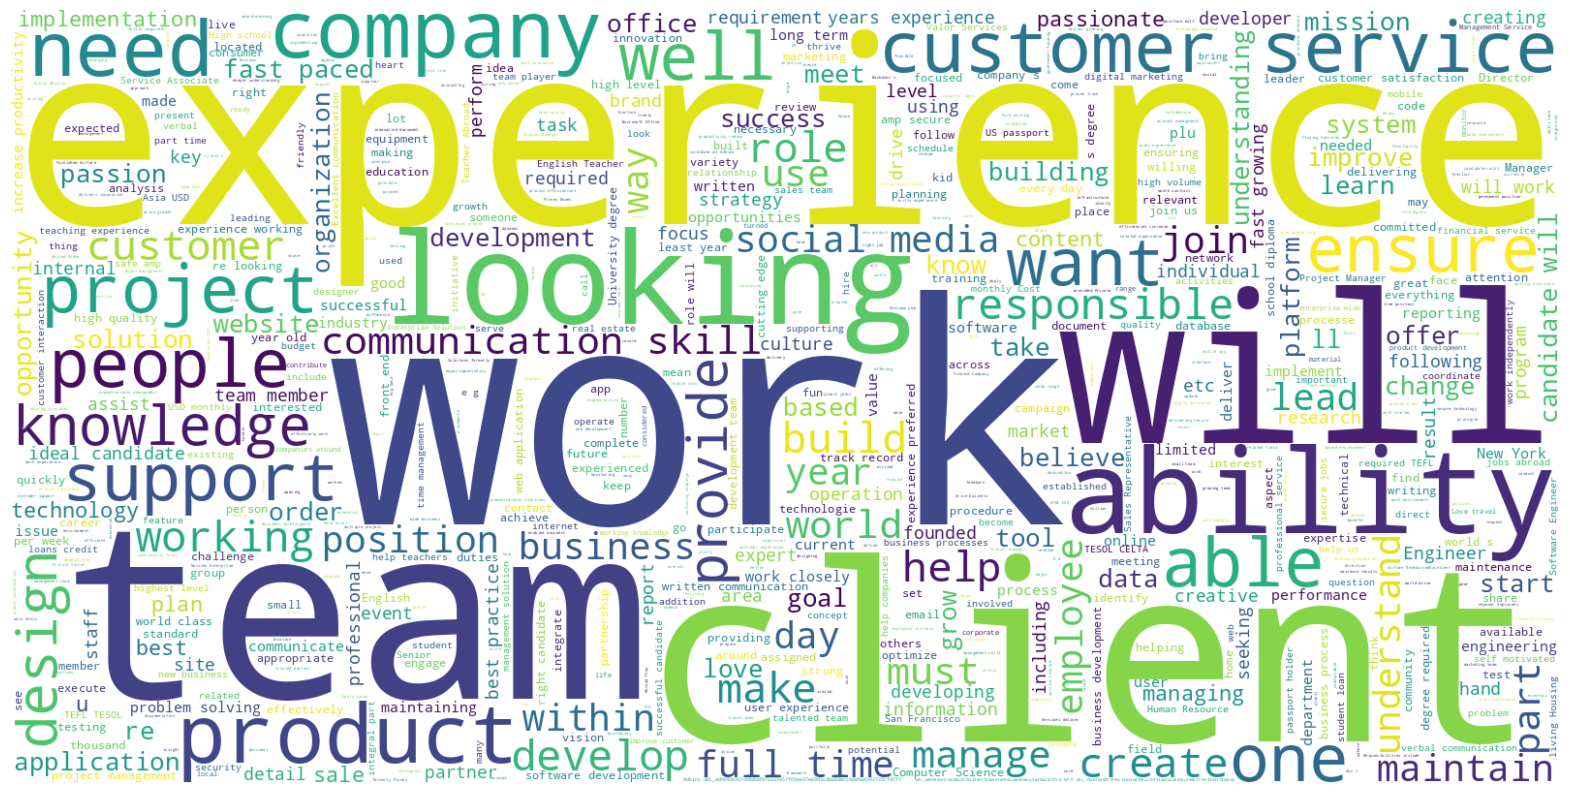

In [ ]:
from wordcloud import WordCloud

# WordCloud for non-fraudulent jobs
plt.figure(figsize=(20, 20))
wc = WordCloud(width=1600, height=800, max_words=3000, background_color="white").generate(" ".join(actual_jobs_text.dropna()))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()



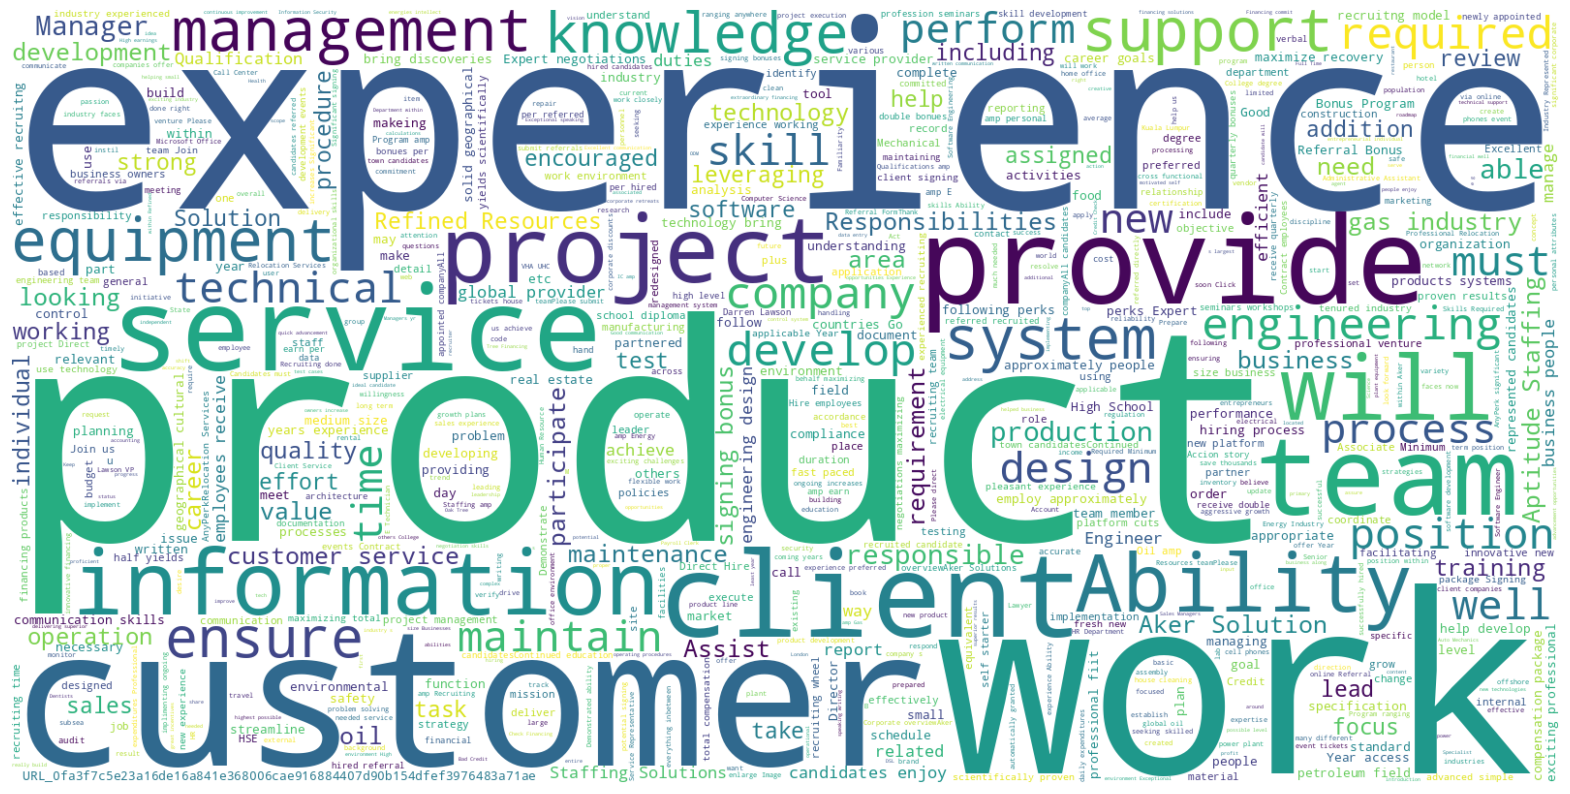

In [ ]:
# WordCloud for fraudulent jobs
plt.figure(figsize=(20, 20))
wc = WordCloud(width=1600, height=800, max_words=3000, background_color="white").generate(" ".join(fraud_jobs_text.dropna()))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

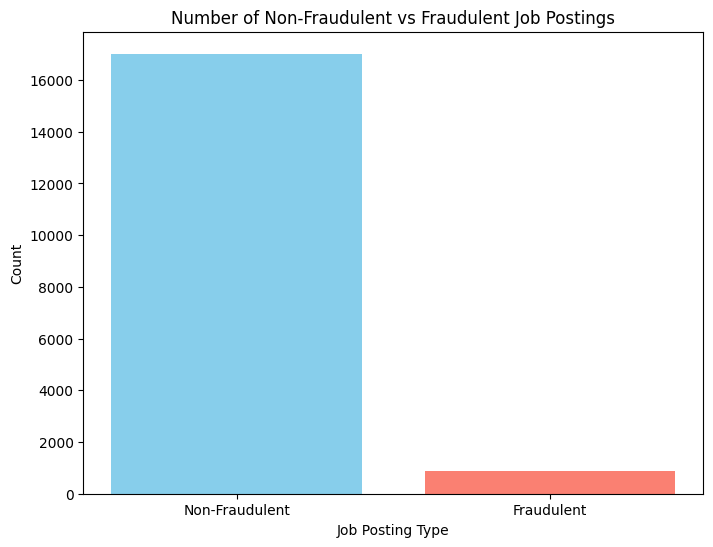

In [ ]:
# plot real or fake job posting
import matplotlib.pyplot as plt

fraud_counts = df['fraudulent'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Non-Fraudulent', 'Fraudulent'], fraud_counts, color=['skyblue', 'salmon'])
plt.title('Number of Non-Fraudulent vs Fraudulent Job Postings')
plt.xlabel('Job Posting Type')
plt.ylabel('Count')
plt.show()